In [1]:
# !source .venv/bin/activate
# !pip3 install -r requirements.txt

In [2]:
import os

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from models.unet_vanilla import UNet
from preprocessing.preprocessor import ImagePreprocessor
from utils.trainer import Callback, SummaryWriter, trainer, batch_generator

# Определим параметры

In [3]:
P = ImagePreprocessor()

test_size = 20
input_size = 256
output_size = 164

album = ["ventura", "santa_rosa"]

# Соберём выборки

In [4]:
imgs = torch.zeros((1500, 3, input_size, input_size))
segms = torch.zeros((1500, 1, output_size, output_size))

idx = 0
for photo in album:
    # Открываем изображения
    img, segm = P.read_image(dir=photo)
    
    # Нарезаем их в тензорном виде
    images = P.destruct_to_chunks(img, chunk_size=output_size, output_size=input_size, mask=False, as_tensor=True)
    segments = P.destruct_to_chunks(segm, chunk_size=output_size, output_size=input_size, mask=True, as_tensor=True)
    
    # Записываем в общий датасет
    imgs[idx:idx+len(images)] = images
    segms[idx:idx+len(segments)] = segments
    idx += len(segments)

imgs = imgs[:idx]
segms = segms[:idx]
print(f"Dataset size before cleaning: X={imgs.shape}, Y={segms.shape}")

Dataset size before cleaning: X=torch.Size([980, 3, 256, 256]), Y=torch.Size([980, 1, 164, 164])


### Очищаем выборку от неразмеченной местности и перемешиваем семплы

In [5]:
imgs, segms = P.clear_dataset(imgs, segms, p=0.10)

# Рандомно встряхиваем индексы чанков в датасете
idxs = np.arange(len(imgs))
np.random.shuffle(idxs)
imgs = imgs[idxs.tolist()]
segms = segms[idxs.tolist()]

print(f"Dataset size after cleaning: X={imgs.shape}, Y={segms.shape}")

Dataset size after cleaning: X=torch.Size([379, 3, 256, 256]), Y=torch.Size([379, 1, 164, 164])


### Разделяем выборки на тест/трейн

In [6]:
img_train, segm_train = imgs[:-test_size], segms[:-test_size]
img_test, segm_test = imgs[-test_size:], segms[-test_size:]

print(f"Train dataset: X={img_train.shape}, Y={segm_train.shape}")
print(f"Test dataset: X={img_test.shape}, Y={segm_test.shape}")

Train dataset: X=torch.Size([359, 3, 256, 256]), Y=torch.Size([359, 1, 164, 164])
Test dataset: X=torch.Size([20, 3, 256, 256]), Y=torch.Size([20, 1, 164, 164])


### Посмотрим на собранные выборки

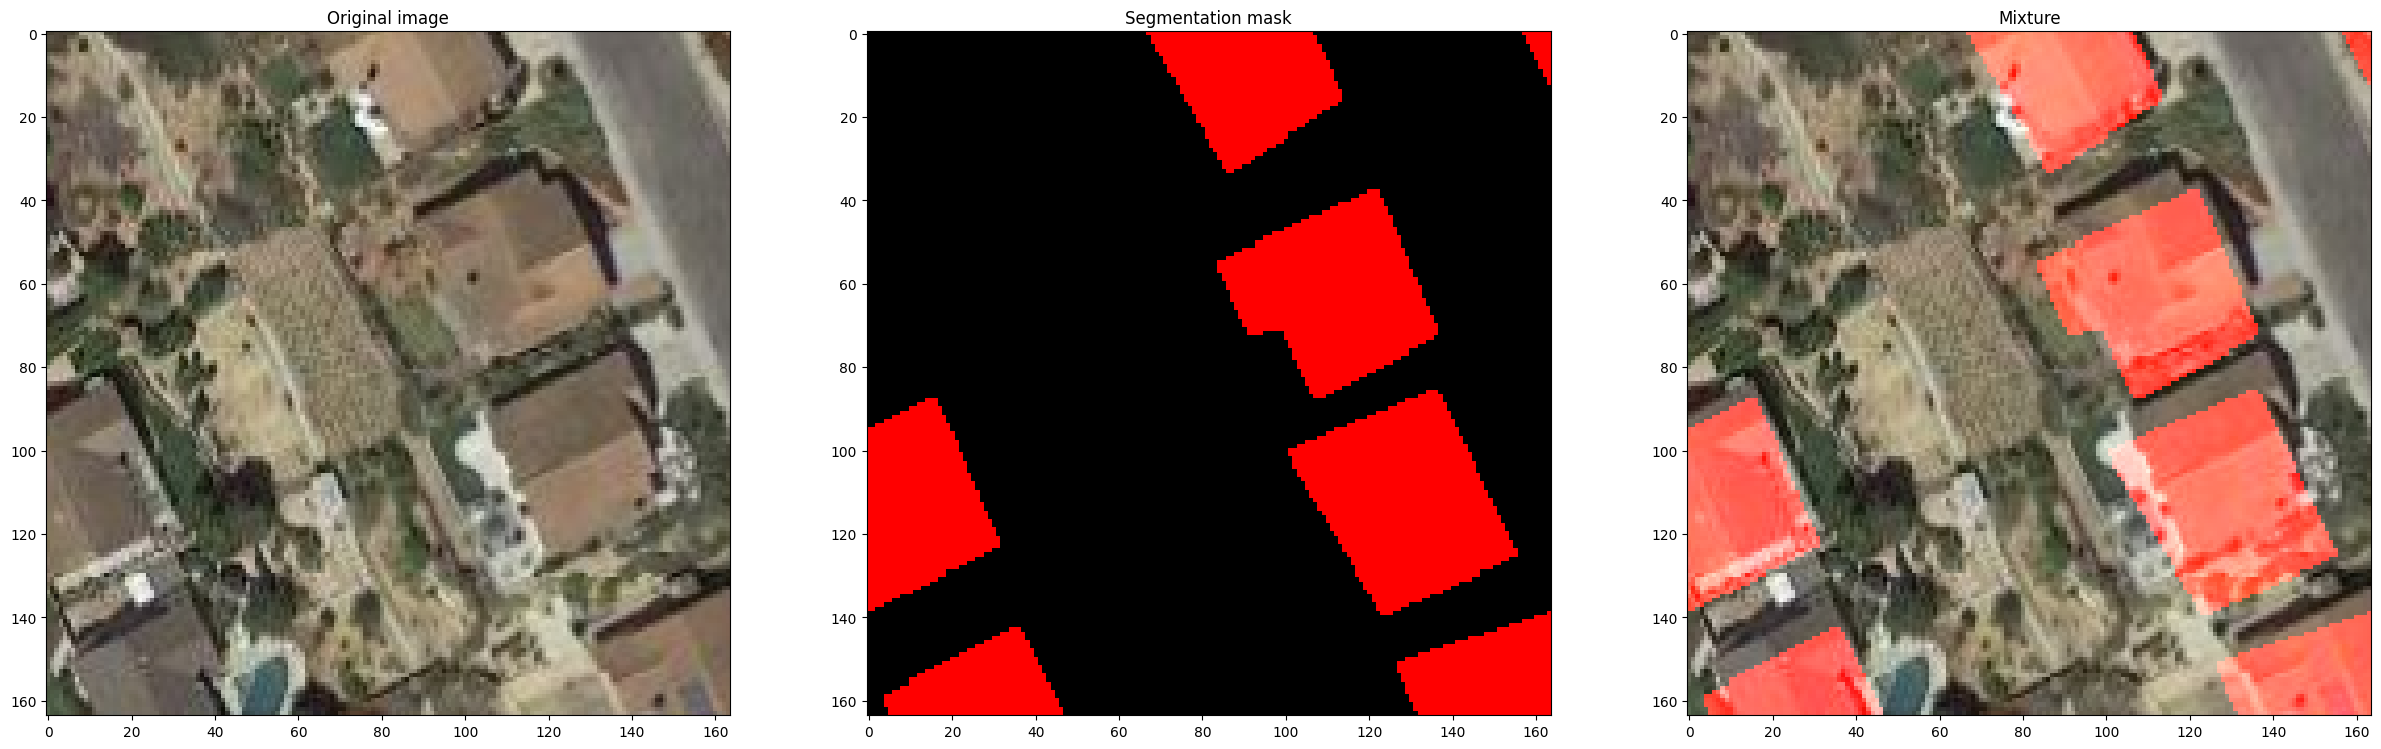

In [7]:
# Трейн
N = np.random.randint(0, len(img_train))

# plt.imshow(torch.transpose(img_train[N], 0, 2))
# plt.show()

P.show(P.to_img(img_train[N]), P.to_img(segm_train[N]))

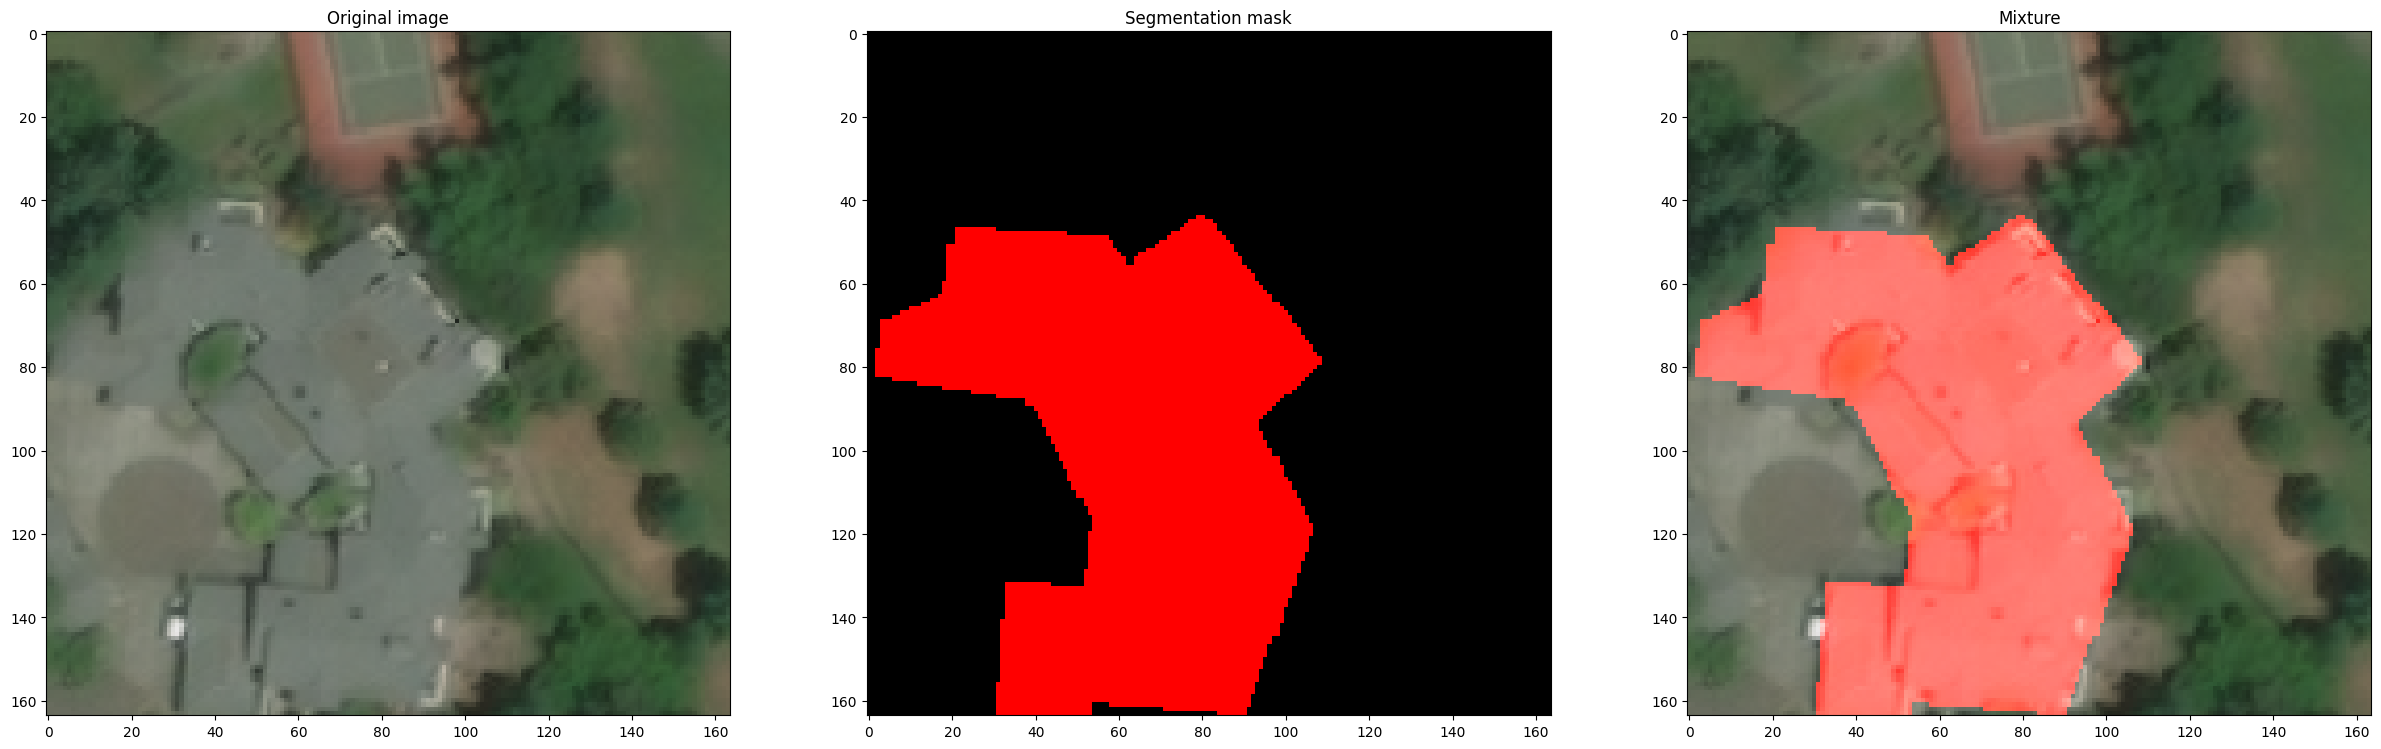

In [8]:
# Тест
N = np.random.randint(0, 10)

# plt.imshow(torch.transpose(img_test[N], 0, 2))
# plt.show()

P.show(P.to_img(img_test[N]), P.to_img(segm_test[N]))

$$$$
$$$$
$$$$
$$$$

# Инициализируем параметры обучения и модель

In [9]:
model = UNet()
print(model)

UNet(
  (encoder): ModuleList(
    (0): UNetEncoderConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (4): ReLU(inplace=True)
      )
      (max_pooling_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): UNetEncoderConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (4): ReLU(inplace=True)
      )
      (max_pooling_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): UNetEncoderConvBlock(
      (conv_blo

### Оценим результаты до обучения

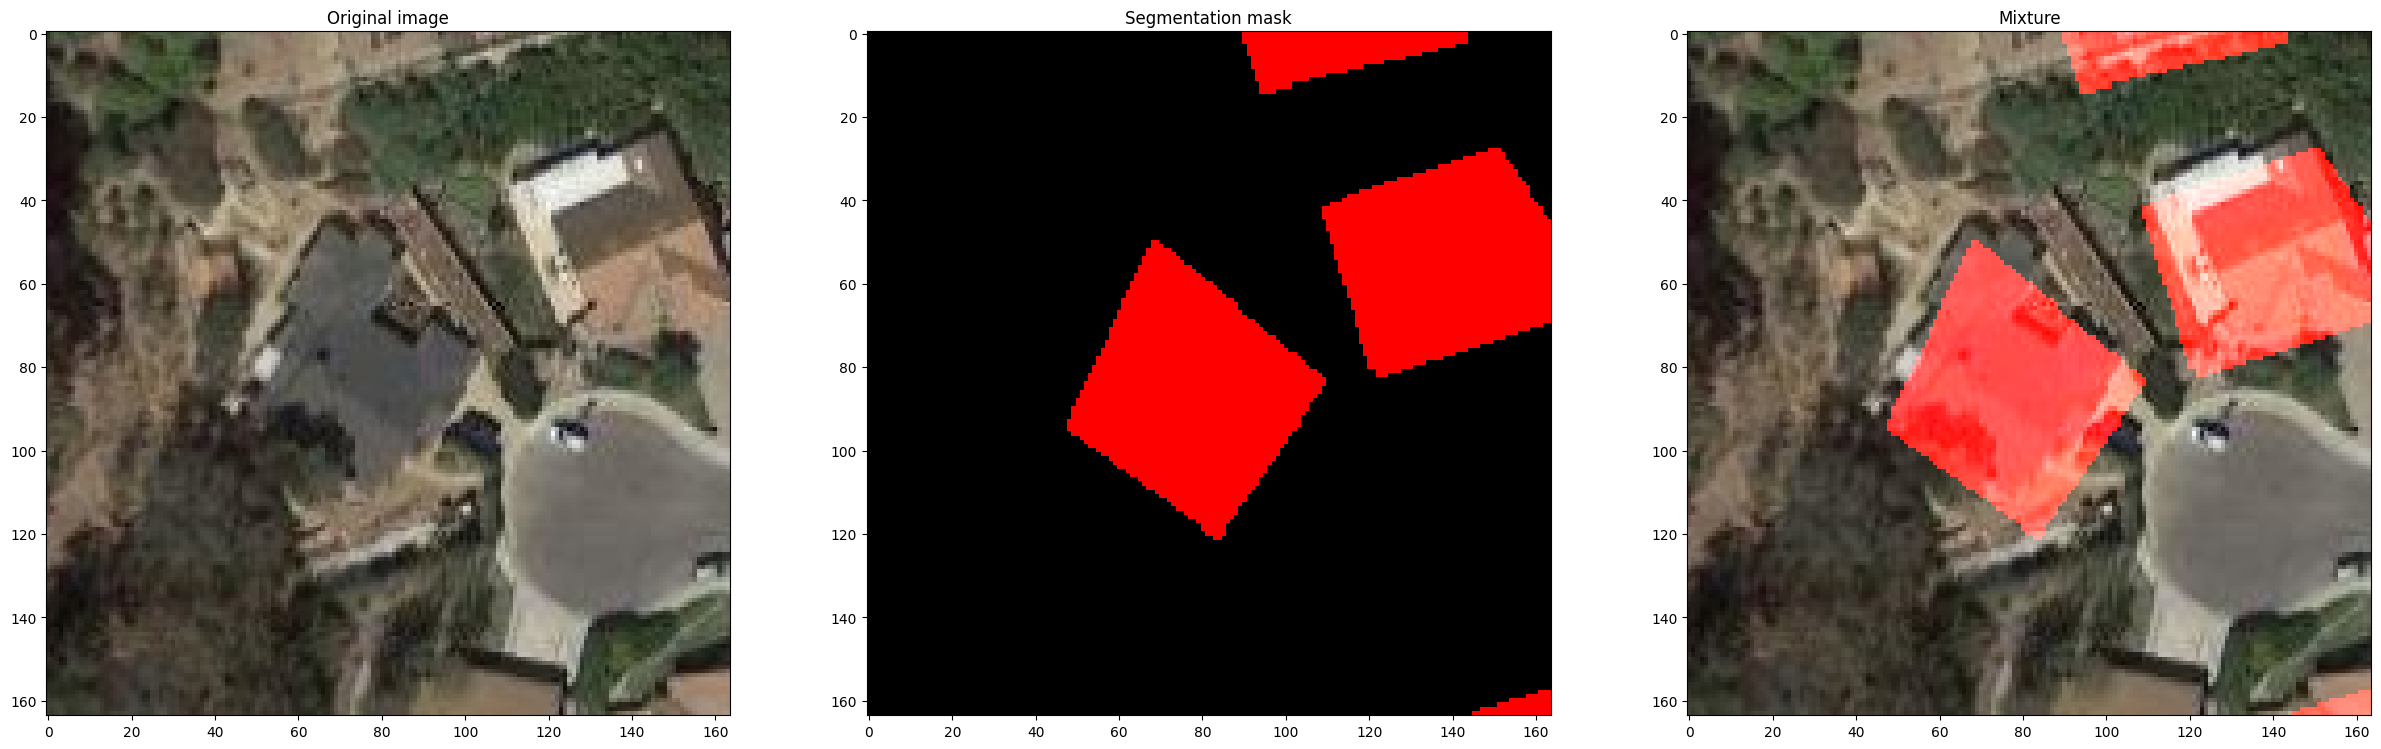

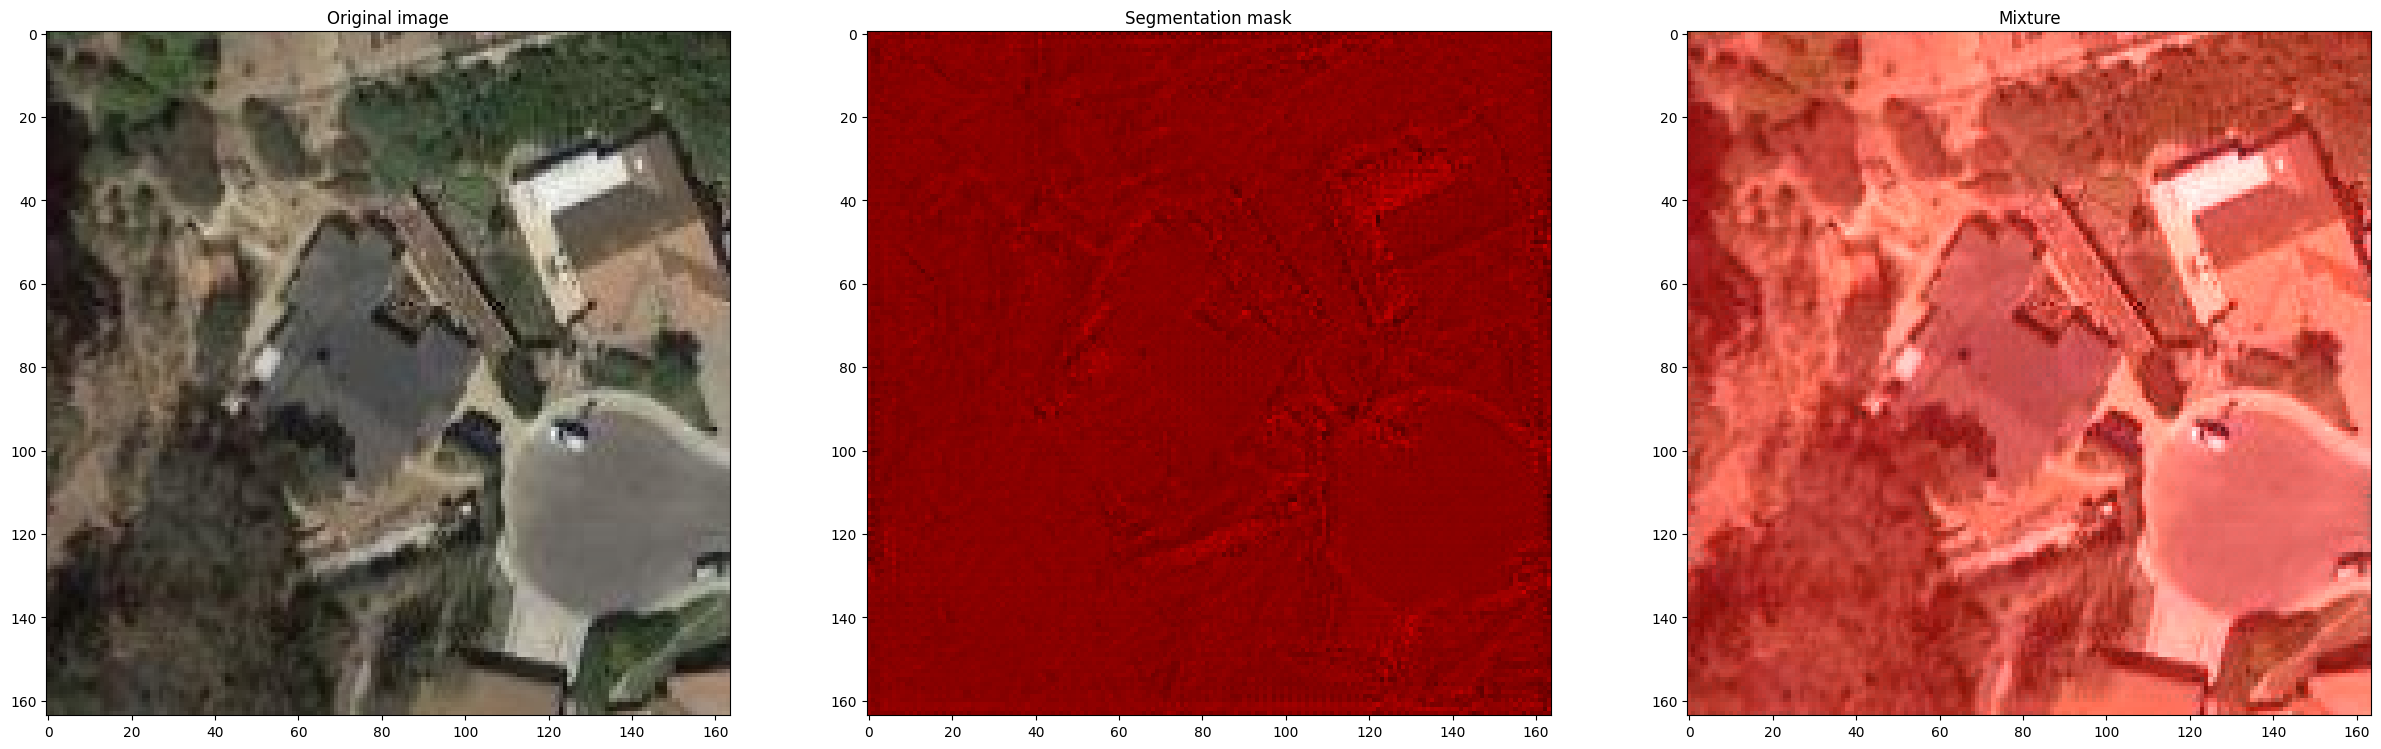

In [10]:
N = np.random.randint(0, len(img_test))

P.show(P.to_img(img_test[N]), P.to_img(segm_test[N]))

out = P.to_img(model(img_test[N:N+1])[0])
P.show(P.to_img(img_test[N]), out)

$$$$
$$$$

### Обучим модель с разными функциями потерь и на разных размерах выборки

In [11]:
LR = 1e-4
OPTIM = torch.optim.Adam

for p in [0.9, 0.75, 0.5]:
    # Выбираем новый размер тренировочной выборки и кол-во эпох
    test_size = int(p * len(imgs))
    epoch = int(2.5 / (1-p))
    
    # Разделяем выборки на тест/трейн
    img_train, segm_train = imgs[:-test_size], segms[:-test_size]
    img_test, segm_test = imgs[-test_size:], segms[-test_size:]
    
    print(f"Epoch count: {epoch}")
    print(f"Train dataset: X={img_train.shape}, Y={segm_train.shape}")
    print(f"Test dataset: X={img_test.shape}, Y={segm_test.shape}")
    
    for loss_function in [torch.nn.BCELoss(), torch.nn.MSELoss()]:
        # Инициализируем модель
        model = UNet()
        
        #  Инициализируем логгер
        writer = SummaryWriter(log_dir=f'logs/test_{p}/{loss_function.__str__()}/small_UNet.Adam.{LR}')
        callback = Callback(img_test, segm_test, writer, loss_function, delimeter=25, batch_size=1)

        trainer(
            X=img_train,
            Y=segm_train,
            model=model,
            loss_function=loss_function,
            optimizer=OPTIM,
            count_of_epoch=epoch,
            batch_size=1,
            lr=LR,
            callback=callback,
        )
        
        # Сохраняем обученную модель
        torch.save(model, f"saved_models/test_{p}/{loss_function.__str__()}/small_UNet.Adam.{LR}")

Epoch count: 25
Train dataset: X=torch.Size([38, 3, 256, 256]), Y=torch.Size([38, 1, 164, 164])
Test dataset: X=torch.Size([341, 3, 256, 256]), Y=torch.Size([341, 1, 164, 164])


epoch:   0%|                                             | 0/25 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

epoch:   0%|                                             | 0/25 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                    | 0/38 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

  0%|                                                   | 0/341 [00:00<?, ?it/s]

Epoch count: 10
Train dataset: X=torch.Size([95, 3, 256, 256]), Y=torch.Size([95, 1, 164, 164])
Test dataset: X=torch.Size([284, 3, 256, 256]), Y=torch.Size([284, 1, 164, 164])


epoch:   0%|                                             | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

epoch:   0%|                                             | 0/10 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                    | 0/95 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

  0%|                                                   | 0/284 [00:00<?, ?it/s]

Epoch count: 5
Train dataset: X=torch.Size([190, 3, 256, 256]), Y=torch.Size([190, 1, 164, 164])
Test dataset: X=torch.Size([189, 3, 256, 256]), Y=torch.Size([189, 1, 164, 164])


epoch:   0%|                                              | 0/5 [00:00<?, ?it/s]

  0%|                                                   | 0/190 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/190 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/190 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/190 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/190 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

epoch:   0%|                                              | 0/5 [00:00<?, ?it/s]

  0%|                                                   | 0/190 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/190 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

  0%|                                                   | 0/190 [00:00<?, ?it/s]

  0%|                                                   | 0/189 [00:00<?, ?it/s]

### Оценим результаты после обучения

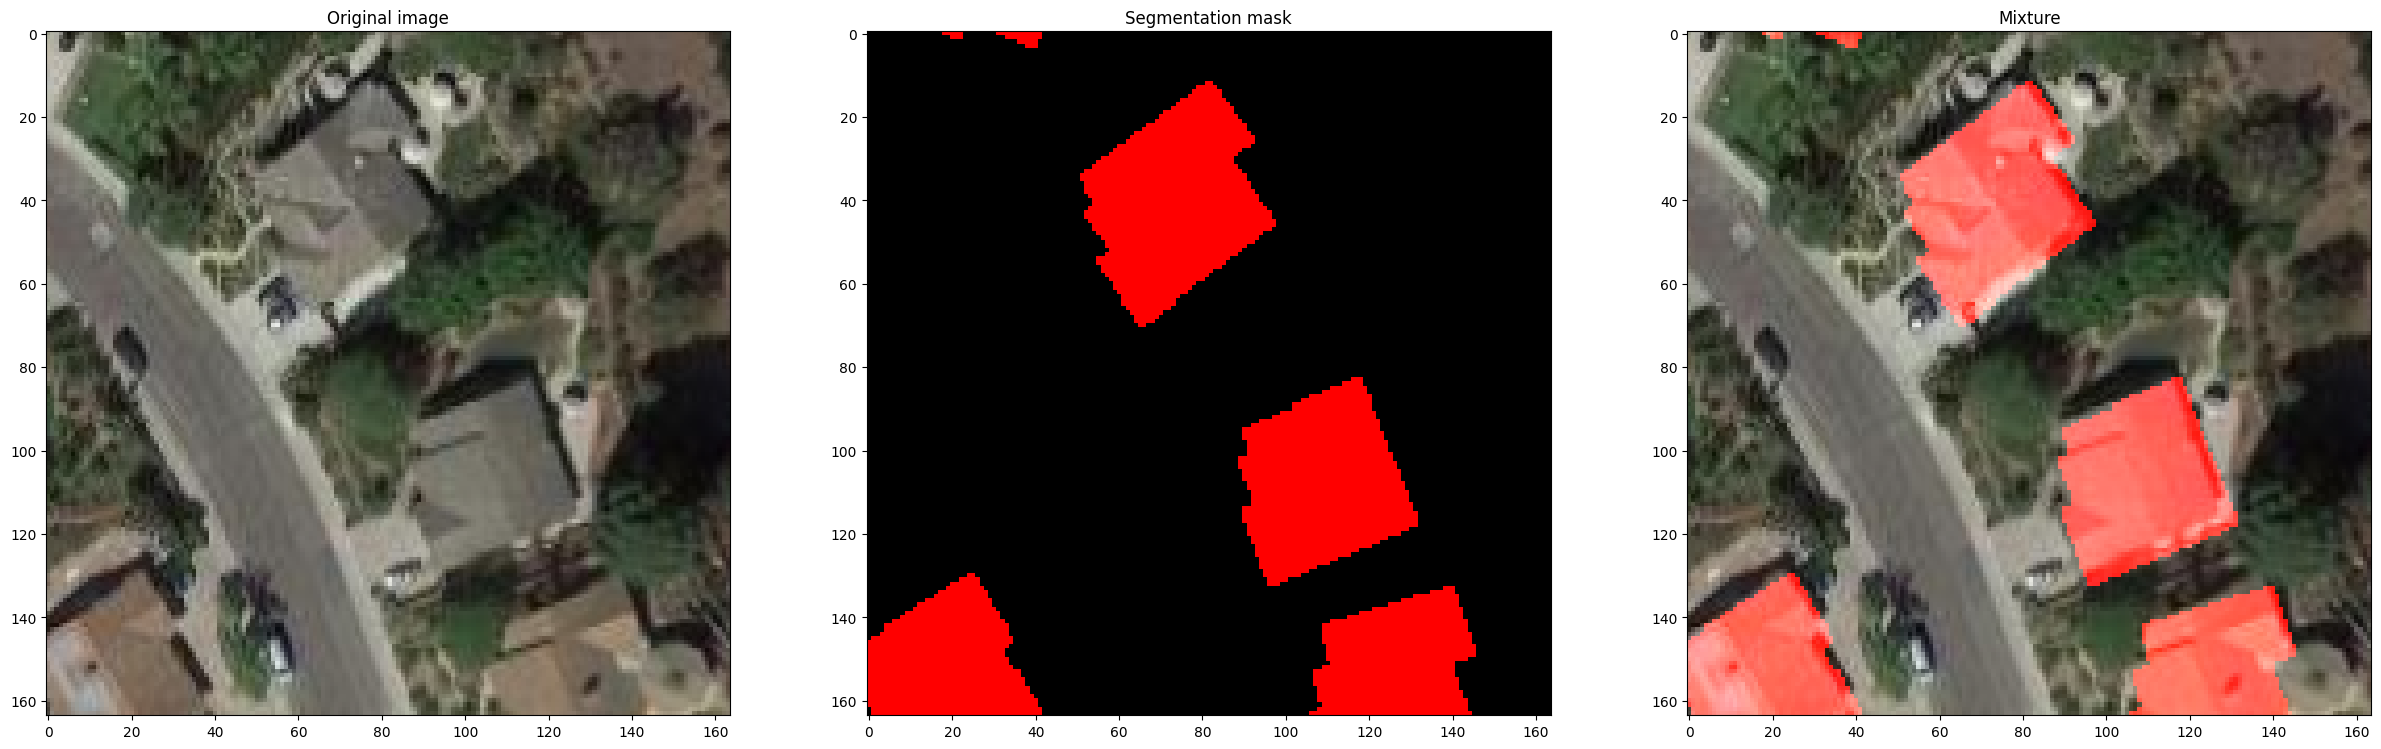

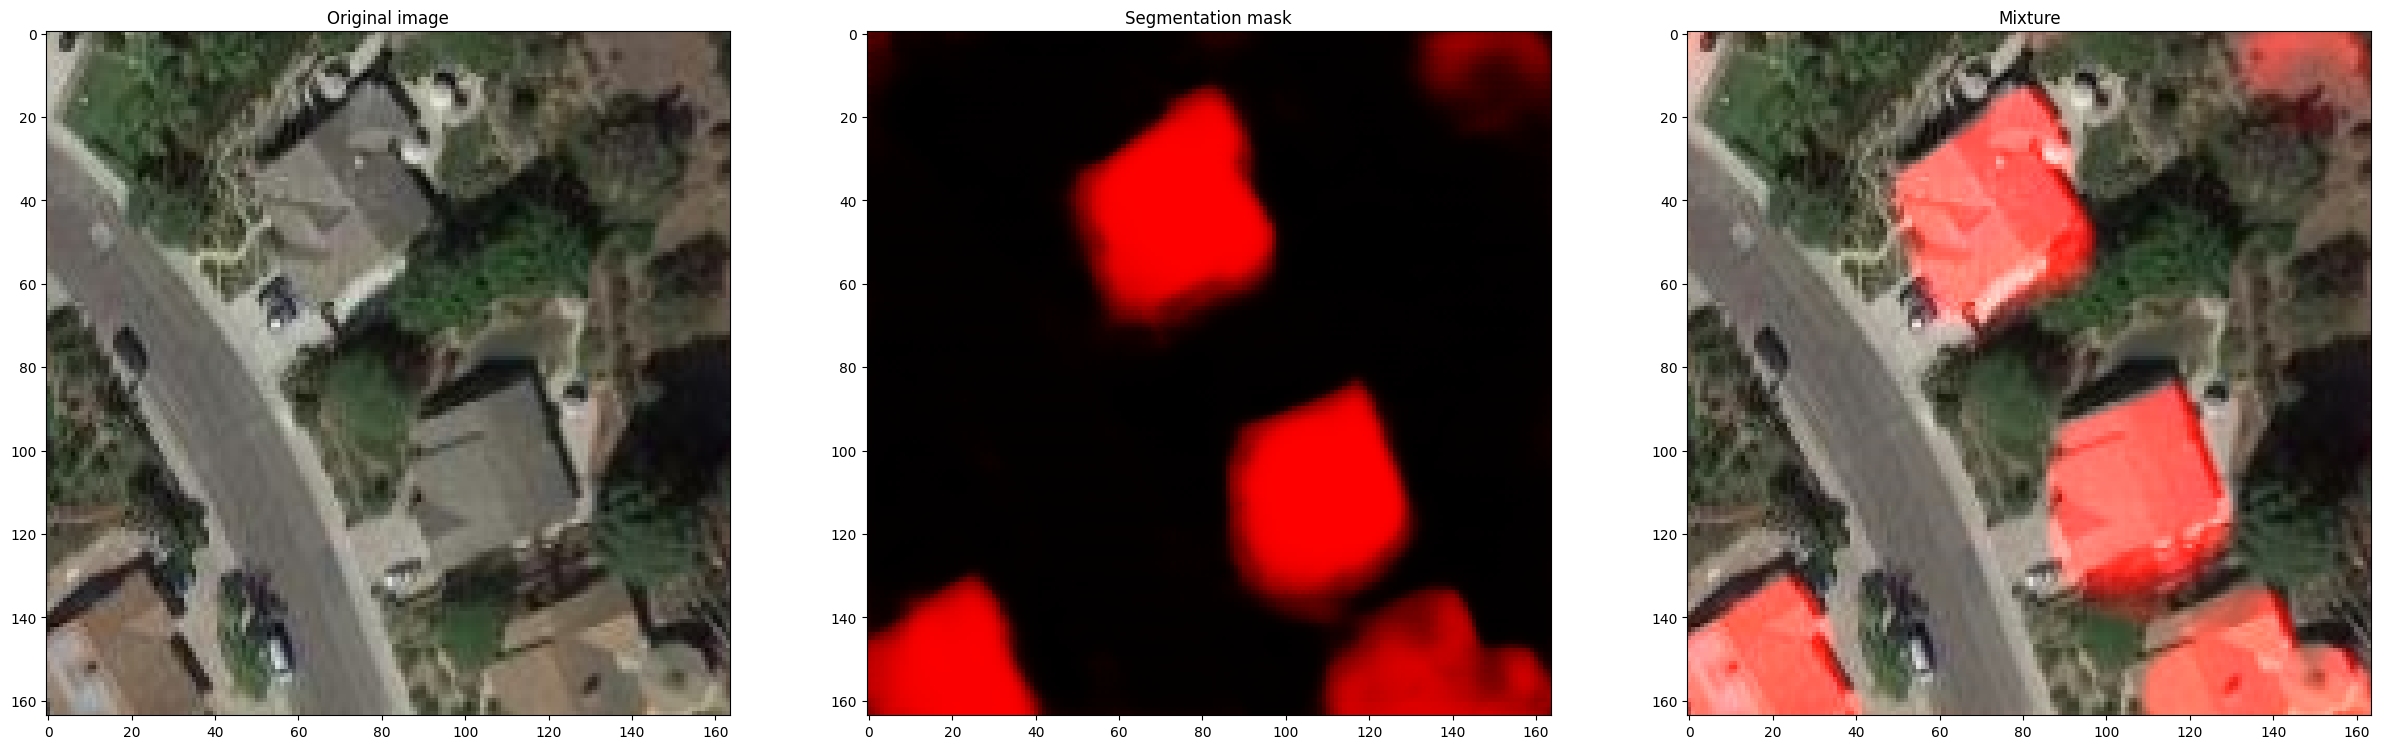

In [13]:
N = np.random.randint(0, len(img_test))

P.show(P.to_img(img_test[N]), P.to_img(segm_test[N]))

out = P.to_img(model(img_test[N:N+1])[0])
P.show(P.to_img(img_test[N]), out)

$$$$
$$$$
$$$$
$$$$
$$$$
$$$$
$$$$
